In [1]:
import numpy as np
import pandas as pd

import lasagne
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\feder\anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import sys
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.feature_selection import SelectKBest

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix
#import scikitplot as skplt
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import make_scorer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import statistics as st


# packages for Survival analyis
import xgboost as xgb

from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored, cumulative_dynamic_auc, concordance_index_ipcw, integrated_brier_score
from sksurv.ensemble import RandomSurvivalForest, ExtraSurvivalTrees
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.kernels import clinical_kernel
from sksurv.svm import FastKernelSurvivalSVM
from sksurv.nonparametric import kaplan_meier_estimator



<frozen importlib._bootstrap>:241: RuntimeWarning: sklearn.tree._splitter.Splitter size changed, may indicate binary incompatibility. Expected 360 from C header, got 1160 from PyObject


## -----------------------------------------<br><br>Import data

In [11]:
df = pd.read_csv('datasets/RW_Molecular_05.08.23_MP.csv')
 
data = df[['IO/IOCT ', 'Surgery','Age_at_IO','Sex', 'Histology', 'Smoking_status', 'PDL1_group', 'Nr_line_IO', 'Stage_IO',  'BMI_IO_Baseline', 'PS_IO_Baseline', 'T_stage_IO', 'N_stage_IO', 'Liver_mets', 'RT_pre_IO', 'Leukocytes_IO_baseline', 'Neutrophylsi_IO_baseline', 'Monocytesal_IO_baseline','Lymphocytes_IO_baseline','NLR','LDH_IO_baseline', 'Bone_mets','Pleura_mets', 'Lymph_nodes_mets', 'Adrenal_mets', 'Brain_mets','Status_OS','OS']]
# M_stage_IO is already excluded

data = data.iloc[:-2,:]

data

,IO/IOCT,Surgery,Age_at_IO,Sex,Histology,Smoking_status,PDL1_group,Nr_line_IO,Stage_IO,BMI_IO_Baseline,...,Lymphocytes_IO_baseline,NLR,LDH_IO_baseline,Bone_mets,Pleura_mets,Lymph_nodes_mets,Adrenal_mets,Brain_mets,Status_OS,OS
0,1.0,0.0,82.0,0.0,0.0,0.0,2.0,1.0,1.0,22.13,...,1400.0,3.357143,324.0,0.0,0.0,1.0,1.0,0.0,0.0,41.0
1,0.0,1.0,73.0,0.0,0.0,1.0,2.0,3.0,1.0,21.09,...,1100.0,4.272727,299.0,1.0,1.0,0.0,0.0,0.0,1.0,5.0
2,0.0,0.0,79.0,1.0,0.0,1.0,3.0,3.0,1.0,25.95,...,1600.0,2.687500,267.0,0.0,0.0,0.0,0.0,0.0,1.0,71.0
3,0.0,0.0,44.0,1.0,0.0,0.0,3.0,1.0,1.0,24.77,...,1300.0,10.615385,588.0,0.0,0.0,1.0,0.0,0.0,1.0,13.0
4,1.0,0.0,63.0,0.0,0.0,1.0,2.0,1.0,1.0,19.36,...,1020.0,7.470588,287.0,1.0,1.0,0.0,1.0,0.0,0.0,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
652,0.0,0.0,63.0,0.0,0.0,1.0,3.0,1.0,1.0,28.40,...,1900.0,2.526316,NaN,1.0,0.0,0.0,0.0,0.0,0.0,70.0
653,1.0,0.0,69.0,1.0,0.0,1.0,NaN,1.0,1.0,29.00,...,1200.0,4.333333,649.0,1.0,0.0,1.0,0.0,1.0,1.0,5.0
654,0.0,0.0,74.0,1.0,0.0,1.0,3.0,2.0,1.0,25.26,...,900.0,4.888889,398.0,0.0,1.0,0.0,0.0,0.0,1.0,6.0
655,0.0,0.0,67.0,0.0,0.0,1.0,3.0,1.0,1.0,21.78,...,2300.0,3.173913,325.0,1.0,0.0,0.0,0.0,0.0,1.0,5.0


In [12]:
print(data.isna().sum())

IO/IOCT                       0
Surgery                       3
Age_at_IO                     0
Sex                           0
Histology                     0
Smoking_status                2
PDL1_group                  122
Nr_line_IO                    0
Stage_IO                      0
BMI_IO_Baseline              53
PS_IO_Baseline                2
T_stage_IO                   40
N_stage_IO                   16
Liver_mets                    0
RT_pre_IO                     0
Leukocytes_IO_baseline       35
Neutrophylsi_IO_baseline     34
Monocytesal_IO_baseline      43
Lymphocytes_IO_baseline      43
NLR                          43
LDH_IO_baseline             103
Bone_mets                     0
Pleura_mets                   0
Lymph_nodes_mets              0
Adrenal_mets                  0
Brain_mets                    0
Status_OS                     0
OS                            0
dtype: int64


In [13]:
# because there's a value written as 9,670 (not 9670) that doesn't allow imputation
data.loc[596,'Leukocytes_IO_baseline']=9670

In [14]:
X_raw=data.iloc[:,:-2]
y_raw=data.iloc[:,[-2,-1]]
y_raw

,Status_OS,OS
0,0.0,41.0
1,1.0,5.0
2,1.0,71.0
3,1.0,13.0
4,0.0,18.0
...,...,...
652,0.0,70.0
653,1.0,5.0
654,1.0,6.0
655,1.0,5.0


## ------------------------------------<br><br> Splitting & imputation

In [15]:
caz = y_raw.groupby(['Status_OS'])['Status_OS'].count()
caz

Status_OS
0.0    146
1.0    511
Name: Status_OS, dtype: int64

In [16]:
X_tr, X_t, y_train, y_test = train_test_split(X_raw, y_raw, random_state=84, test_size = 0.1)
X_tr

,IO/IOCT,Surgery,Age_at_IO,Sex,Histology,Smoking_status,PDL1_group,Nr_line_IO,Stage_IO,BMI_IO_Baseline,...,Neutrophylsi_IO_baseline,Monocytesal_IO_baseline,Lymphocytes_IO_baseline,NLR,LDH_IO_baseline,Bone_mets,Pleura_mets,Lymph_nodes_mets,Adrenal_mets,Brain_mets
382,0.0,0.0,69.0,1.0,0.0,1.0,1.0,1.0,1.0,22.91,...,4700.0,500.0,1900.0,2.473684,283.0,0.0,1.0,0.0,1.0,1.0
567,0.0,0.0,70.0,0.0,0.0,1.0,1.0,2.0,1.0,17.67,...,5910.0,670.0,1040.0,5.682692,1746.0,1.0,0.0,1.0,0.0,1.0
85,1.0,0.0,77.0,1.0,0.0,1.0,1.0,1.0,1.0,22.86,...,3500.0,800.0,2100.0,1.666667,NaN,0.0,0.0,0.0,0.0,0.0
193,0.0,0.0,61.0,1.0,1.0,1.0,1.0,2.0,1.0,31.07,...,8100.0,600.0,1200.0,6.750000,308.0,0.0,1.0,0.0,0.0,0.0
388,0.0,0.0,65.0,1.0,1.0,1.0,2.0,1.0,1.0,23.99,...,5400.0,500.0,1100.0,4.909091,245.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,1.0,0.0,60.0,1.0,0.0,NaN,1.0,1.0,1.0,21.91,...,530.0,500.0,700.0,0.757143,443.0,1.0,0.0,0.0,0.0,0.0
206,0.0,0.0,80.0,1.0,0.0,1.0,3.0,3.0,1.0,23.15,...,7300.0,700.0,800.0,9.125000,NaN,0.0,0.0,1.0,0.0,0.0
380,0.0,0.0,67.0,1.0,0.0,1.0,3.0,1.0,1.0,25.25,...,11500.0,900.0,1200.0,9.583333,254.0,1.0,0.0,1.0,0.0,0.0
501,0.0,0.0,84.0,0.0,0.0,1.0,3.0,1.0,1.0,25.45,...,6700.0,500.0,1400.0,4.785714,363.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# IMPUTATION

# define imputer
imputer = IterativeImputer()
# fit on the dataset
imputer.fit(X_tr)
# transform the dataset
X = imputer.transform(X_tr)
X1 = imputer.transform(X_t)
X_train = pd.DataFrame(X, columns=X_raw.columns)
X_test = pd.DataFrame(X1, columns=X_raw.columns)
X_train
# This Multivariate approach assigns imputed values by solving a linear regression problem performed on other features. 
# Each feature containing missing values is, in turn, considered the target of the regression model. The
# imputation algorithm is fitted on the training set and then applied to both training and test dataset

,IO/IOCT,Surgery,Age_at_IO,Sex,Histology,Smoking_status,PDL1_group,Nr_line_IO,Stage_IO,BMI_IO_Baseline,...,Neutrophylsi_IO_baseline,Monocytesal_IO_baseline,Lymphocytes_IO_baseline,NLR,LDH_IO_baseline,Bone_mets,Pleura_mets,Lymph_nodes_mets,Adrenal_mets,Brain_mets
0,0.0,0.0,69.0,1.0,0.0,1.000000,1.0,1.0,1.0,22.91,...,4700.0,500.0,1900.0,2.473684,283.000000,0.0,1.0,0.0,1.0,1.0
1,0.0,0.0,70.0,0.0,0.0,1.000000,1.0,2.0,1.0,17.67,...,5910.0,670.0,1040.0,5.682692,1746.000000,1.0,0.0,1.0,0.0,1.0
2,1.0,0.0,77.0,1.0,0.0,1.000000,1.0,1.0,1.0,22.86,...,3500.0,800.0,2100.0,1.666667,342.256585,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,61.0,1.0,1.0,1.000000,1.0,2.0,1.0,31.07,...,8100.0,600.0,1200.0,6.750000,308.000000,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,65.0,1.0,1.0,1.000000,2.0,1.0,1.0,23.99,...,5400.0,500.0,1100.0,4.909091,245.000000,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,1.0,0.0,60.0,1.0,0.0,0.857789,1.0,1.0,1.0,21.91,...,530.0,500.0,700.0,0.757143,443.000000,1.0,0.0,0.0,0.0,0.0
587,0.0,0.0,80.0,1.0,0.0,1.000000,3.0,3.0,1.0,23.15,...,7300.0,700.0,800.0,9.125000,381.574993,0.0,0.0,1.0,0.0,0.0
588,0.0,0.0,67.0,1.0,0.0,1.000000,3.0,1.0,1.0,25.25,...,11500.0,900.0,1200.0,9.583333,254.000000,1.0,0.0,1.0,0.0,0.0
589,0.0,0.0,84.0,0.0,0.0,1.000000,3.0,1.0,1.0,25.45,...,6700.0,500.0,1400.0,4.785714,363.000000,0.0,0.0,0.0,0.0,0.0


In [18]:
# ROUND THE VALUES IMPUTED THAT NEED TO BE INTEGERS (without M_stage_IO)

X_train['Smoking_status']=round(X_train['Smoking_status']).astype('int64')
X_test['Smoking_status']=round(X_test['Smoking_status']).astype('int64')

X_train['PDL1_group']=round(X_train['PDL1_group']).astype('int64')
X_test['PDL1_group']=round(X_test['PDL1_group']).astype('int64')

X_train['Nr_line_IO']=round(X_train['Nr_line_IO']).astype('int64')
X_test['Nr_line_IO']=round(X_test['Nr_line_IO']).astype('int64')


X_train['Stage_IO']=round(X_train['Stage_IO']).astype('int64')
X_test['Stage_IO']=round(X_test['Stage_IO']).astype('int64')


X_train['PS_IO_Baseline']=round(X_train['PS_IO_Baseline']).astype('int64')
X_test['PS_IO_Baseline']=round(X_test['PS_IO_Baseline']).astype('int64')


X_train['T_stage_IO']=round(X_train['T_stage_IO']).astype('int64')
X_test['T_stage_IO']=round(X_test['T_stage_IO']).astype('int64')


X_train['N_stage_IO']=round(X_train['N_stage_IO']).astype('int64')
X_test['N_stage_IO']=round(X_test['N_stage_IO']).astype('int64')


X_train

,IO/IOCT,Surgery,Age_at_IO,Sex,Histology,Smoking_status,PDL1_group,Nr_line_IO,Stage_IO,BMI_IO_Baseline,...,Neutrophylsi_IO_baseline,Monocytesal_IO_baseline,Lymphocytes_IO_baseline,NLR,LDH_IO_baseline,Bone_mets,Pleura_mets,Lymph_nodes_mets,Adrenal_mets,Brain_mets
0,0.0,0.0,69.0,1.0,0.0,1,1,1,1,22.91,...,4700.0,500.0,1900.0,2.473684,283.000000,0.0,1.0,0.0,1.0,1.0
1,0.0,0.0,70.0,0.0,0.0,1,1,2,1,17.67,...,5910.0,670.0,1040.0,5.682692,1746.000000,1.0,0.0,1.0,0.0,1.0
2,1.0,0.0,77.0,1.0,0.0,1,1,1,1,22.86,...,3500.0,800.0,2100.0,1.666667,342.256585,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,61.0,1.0,1.0,1,1,2,1,31.07,...,8100.0,600.0,1200.0,6.750000,308.000000,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,65.0,1.0,1.0,1,2,1,1,23.99,...,5400.0,500.0,1100.0,4.909091,245.000000,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,1.0,0.0,60.0,1.0,0.0,1,1,1,1,21.91,...,530.0,500.0,700.0,0.757143,443.000000,1.0,0.0,0.0,0.0,0.0
587,0.0,0.0,80.0,1.0,0.0,1,3,3,1,23.15,...,7300.0,700.0,800.0,9.125000,381.574993,0.0,0.0,1.0,0.0,0.0
588,0.0,0.0,67.0,1.0,0.0,1,3,1,1,25.25,...,11500.0,900.0,1200.0,9.583333,254.000000,1.0,0.0,1.0,0.0,0.0
589,0.0,0.0,84.0,0.0,0.0,1,3,1,1,25.45,...,6700.0,500.0,1400.0,4.785714,363.000000,0.0,0.0,0.0,0.0,0.0


## --------------------------------<br><br>FEATURE ENGINEERING<br><br>Conversion of some features to the logarithmic version

In [19]:
X_train.dtypes

IO/IOCT                     float64
Surgery                     float64
Age_at_IO                   float64
Sex                         float64
Histology                   float64
Smoking_status                int64
PDL1_group                    int64
Nr_line_IO                    int64
Stage_IO                      int64
BMI_IO_Baseline             float64
PS_IO_Baseline                int64
T_stage_IO                    int64
N_stage_IO                    int64
Liver_mets                  float64
RT_pre_IO                   float64
Leukocytes_IO_baseline      float64
Neutrophylsi_IO_baseline    float64
Monocytesal_IO_baseline     float64
Lymphocytes_IO_baseline     float64
NLR                         float64
LDH_IO_baseline             float64
Bone_mets                   float64
Pleura_mets                 float64
Lymph_nodes_mets            float64
Adrenal_mets                float64
Brain_mets                  float64
dtype: object

In [20]:
# before splitting between categorical and numerical, some features need to be converted to integers, despite they are float


X_train[['IO/IOCT ','Surgery','Sex','Histology','Liver_mets','RT_pre_IO','Bone_mets','Pleura_mets','Lymph_nodes_mets','Adrenal_mets','Brain_mets']]=X_train[['IO/IOCT ','Surgery','Sex','Histology','Liver_mets','RT_pre_IO','Bone_mets','Pleura_mets','Lymph_nodes_mets','Adrenal_mets','Brain_mets']].astype('int64')
X_test[['IO/IOCT ','Surgery','Sex','Histology','Liver_mets','RT_pre_IO','Bone_mets','Pleura_mets','Lymph_nodes_mets','Adrenal_mets','Brain_mets']]=X_test[['IO/IOCT ','Surgery','Sex','Histology','Liver_mets','RT_pre_IO','Bone_mets','Pleura_mets','Lymph_nodes_mets','Adrenal_mets','Brain_mets']].astype('int64')
X_train

,IO/IOCT,Surgery,Age_at_IO,Sex,Histology,Smoking_status,PDL1_group,Nr_line_IO,Stage_IO,BMI_IO_Baseline,...,Neutrophylsi_IO_baseline,Monocytesal_IO_baseline,Lymphocytes_IO_baseline,NLR,LDH_IO_baseline,Bone_mets,Pleura_mets,Lymph_nodes_mets,Adrenal_mets,Brain_mets
0,0,0,69.0,1,0,1,1,1,1,22.91,...,4700.0,500.0,1900.0,2.473684,283.000000,0,1,0,1,1
1,0,0,70.0,0,0,1,1,2,1,17.67,...,5910.0,670.0,1040.0,5.682692,1746.000000,1,0,1,0,1
2,1,0,77.0,1,0,1,1,1,1,22.86,...,3500.0,800.0,2100.0,1.666667,342.256585,0,0,0,0,0
3,0,0,61.0,1,1,1,1,2,1,31.07,...,8100.0,600.0,1200.0,6.750000,308.000000,0,1,0,0,0
4,0,0,65.0,1,1,1,2,1,1,23.99,...,5400.0,500.0,1100.0,4.909091,245.000000,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,1,0,60.0,1,0,1,1,1,1,21.91,...,530.0,500.0,700.0,0.757143,443.000000,1,0,0,0,0
587,0,0,80.0,1,0,1,3,3,1,23.15,...,7300.0,700.0,800.0,9.125000,381.574993,0,0,1,0,0
588,0,0,67.0,1,0,1,3,1,1,25.25,...,11500.0,900.0,1200.0,9.583333,254.000000,1,0,1,0,0
589,0,0,84.0,0,0,1,3,1,1,25.45,...,6700.0,500.0,1400.0,4.785714,363.000000,0,0,0,0,0


In [21]:
X_train.dtypes

IO/IOCT                       int64
Surgery                       int64
Age_at_IO                   float64
Sex                           int64
Histology                     int64
Smoking_status                int64
PDL1_group                    int64
Nr_line_IO                    int64
Stage_IO                      int64
BMI_IO_Baseline             float64
PS_IO_Baseline                int64
T_stage_IO                    int64
N_stage_IO                    int64
Liver_mets                    int64
RT_pre_IO                     int64
Leukocytes_IO_baseline      float64
Neutrophylsi_IO_baseline    float64
Monocytesal_IO_baseline     float64
Lymphocytes_IO_baseline     float64
NLR                         float64
LDH_IO_baseline             float64
Bone_mets                     int64
Pleura_mets                   int64
Lymph_nodes_mets              int64
Adrenal_mets                  int64
Brain_mets                    int64
dtype: object

In [22]:
categorical_features_indices = np.where(X_train.dtypes == 'int64')[0]
X_train_categorical=X_train.iloc[:,categorical_features_indices]
X_test_categorical=X_test.iloc[:,categorical_features_indices]
X_train_categorical

,IO/IOCT,Surgery,Sex,Histology,Smoking_status,PDL1_group,Nr_line_IO,Stage_IO,PS_IO_Baseline,T_stage_IO,N_stage_IO,Liver_mets,RT_pre_IO,Bone_mets,Pleura_mets,Lymph_nodes_mets,Adrenal_mets,Brain_mets
0,0,0,1,0,1,1,1,1,0,3,2,0,0,0,1,0,1,1
1,0,0,0,0,1,1,2,1,1,4,3,1,1,1,0,1,0,1
2,1,0,1,0,1,1,1,1,1,4,2,0,0,0,0,0,0,0
3,0,0,1,1,1,1,2,1,1,3,3,0,1,0,1,0,0,0
4,0,0,1,1,1,2,1,1,1,4,2,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,1,0,1,0,1,1,1,1,1,1,2,0,0,1,0,0,0,0
587,0,0,1,0,1,3,3,1,1,4,2,0,1,0,0,1,0,0
588,0,0,1,0,1,3,1,1,0,4,2,0,0,1,0,1,0,0
589,0,0,0,0,1,3,1,1,1,4,2,0,1,0,0,0,0,0


In [23]:
numerical_features_indices = np.where(X_train.dtypes == 'float64')[0]
X_train_numerical=X_train.iloc[:,numerical_features_indices]
X_test_numerical=X_test.iloc[:,numerical_features_indices]
X_train_numerical

,Age_at_IO,BMI_IO_Baseline,Leukocytes_IO_baseline,Neutrophylsi_IO_baseline,Monocytesal_IO_baseline,Lymphocytes_IO_baseline,NLR,LDH_IO_baseline
0,69.0,22.91,7410.0,4700.0,500.0,1900.0,2.473684,283.000000
1,70.0,17.67,7890.0,5910.0,670.0,1040.0,5.682692,1746.000000
2,77.0,22.86,6700.0,3500.0,800.0,2100.0,1.666667,342.256585
3,61.0,31.07,10330.0,8100.0,600.0,1200.0,6.750000,308.000000
4,65.0,23.99,7140.0,5400.0,500.0,1100.0,4.909091,245.000000
...,...,...,...,...,...,...,...,...
586,60.0,21.91,6750.0,530.0,500.0,700.0,0.757143,443.000000
587,80.0,23.15,9130.0,7300.0,700.0,800.0,9.125000,381.574993
588,67.0,25.25,14230.0,11500.0,900.0,1200.0,9.583333,254.000000
589,84.0,25.45,10260.0,6700.0,500.0,1400.0,4.785714,363.000000


array([[<Axes: title={'center': 'Age_at_IO'}>,
        <Axes: title={'center': 'BMI_IO_Baseline'}>,
        <Axes: title={'center': 'Leukocytes_IO_baseline'}>,
        <Axes: title={'center': 'Neutrophylsi_IO_baseline'}>],
       [<Axes: title={'center': 'Monocytesal_IO_baseline'}>,
        <Axes: title={'center': 'Lymphocytes_IO_baseline'}>,
        <Axes: title={'center': 'NLR'}>,
        <Axes: title={'center': 'LDH_IO_baseline'}>],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object)

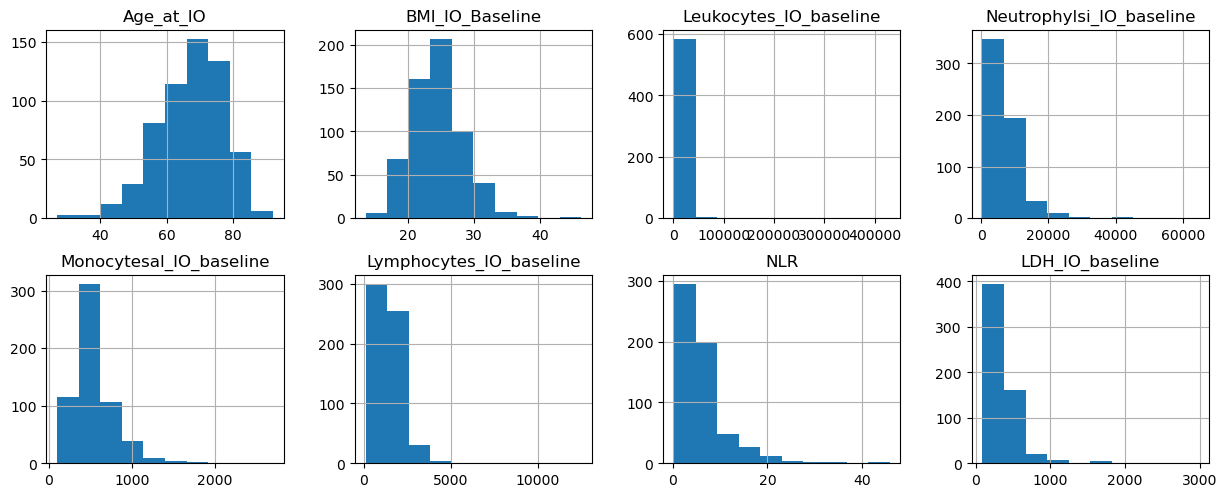

In [24]:
X=X_train_numerical


X.hist(layout=(4,4), figsize=(15,12))



C:\Users\feder\AppData\Local\Temp\ipykernel_26460\2394409172.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['logLeuko']=X['Leukocytes_IO_baseline'].apply(lambda x: math.log(x+1))
C:\Users\feder\AppData\Local\Temp\ipykernel_26460\2394409172.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['logLDH']=X['LDH_IO_baseline'].apply(lambda x: math.log(x+1))


array([[<Axes: title={'center': 'Leukocytes_IO_baseline'}>,
        <Axes: title={'center': 'logLeuko'}>],
       [<Axes: title={'center': 'LDH_IO_baseline'}>,
        <Axes: title={'center': 'logLDH'}>],
       [<Axes: >, <Axes: >]], dtype=object)

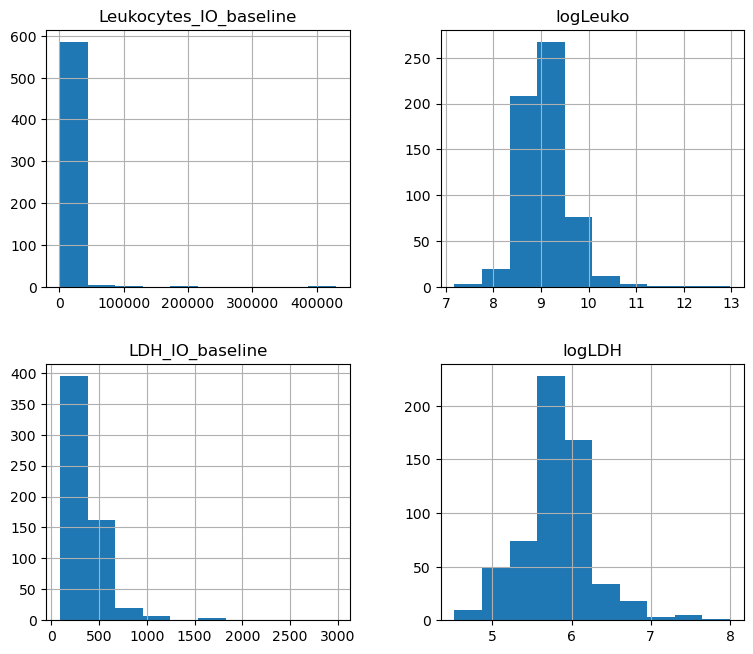

In [25]:
import math
X['logLeuko']=X['Leukocytes_IO_baseline'].apply(lambda x: math.log(x+1))
#X['logNLR']=X['NLR'].apply(lambda x: math.log(x+1))
X['logLDH']=X['LDH_IO_baseline'].apply(lambda x: math.log(x+1))

#X[['Leukocytes_IO_baseline','logLeuko','NLR','logNLR','LDH_IO_baseline','logLDH']].hist(layout=(3,2), figsize=(9,12))
X[['Leukocytes_IO_baseline','logLeuko','LDH_IO_baseline','logLDH']].hist(layout=(3,2), figsize=(9,12))

# They resembles more or less a normal distribution, so I use them for the training of the models

In [26]:
#X=X.drop(['Leukocytes_IO_baseline','NLR','LDH_IO_baseline'],axis=1)
X=X.drop(['Leukocytes_IO_baseline','LDH_IO_baseline'],axis=1)
X

,Age_at_IO,BMI_IO_Baseline,Neutrophylsi_IO_baseline,Monocytesal_IO_baseline,Lymphocytes_IO_baseline,NLR,logLeuko,logLDH
0,69.0,22.91,4700.0,500.0,1900.0,2.473684,8.910721,5.648974
1,70.0,17.67,5910.0,670.0,1040.0,5.682692,8.973478,7.465655
2,77.0,22.86,3500.0,800.0,2100.0,1.666667,8.810012,5.838478
3,61.0,31.07,8100.0,600.0,1200.0,6.750000,9.242904,5.733341
4,65.0,23.99,5400.0,500.0,1100.0,4.909091,8.873608,5.505332
...,...,...,...,...,...,...,...,...
586,60.0,21.91,530.0,500.0,700.0,0.757143,8.817446,6.095825
587,80.0,23.15,7300.0,700.0,800.0,9.125000,9.119430,5.946925
588,67.0,25.25,11500.0,900.0,1200.0,9.583333,9.563178,5.541264
589,84.0,25.45,6700.0,500.0,1400.0,4.785714,9.236106,5.897154


In [27]:
X_train_numerical=X

In [28]:
X_test_numerical['logLeuko']=X_test_numerical['Leukocytes_IO_baseline'].apply(lambda x: math.log(x+1))
#X_test_numerical['logNLR']=X_test_numerical['NLR'].apply(lambda x: math.log(x+1))
X_test_numerical['logLDH']=X_test_numerical['LDH_IO_baseline'].apply(lambda x: math.log(x+1))

#X_test_numerical=X_test_numerical.drop(['Leukocytes_IO_baseline','NLR','LDH_IO_baseline'],axis=1)
X_test_numerical=X_test_numerical.drop(['Leukocytes_IO_baseline','LDH_IO_baseline'],axis=1)
X_test_numerical

C:\Users\feder\AppData\Local\Temp\ipykernel_26460\986962250.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_numerical['logLeuko']=X_test_numerical['Leukocytes_IO_baseline'].apply(lambda x: math.log(x+1))
C:\Users\feder\AppData\Local\Temp\ipykernel_26460\986962250.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_numerical['logLDH']=X_test_numerical['LDH_IO_baseline'].apply(lambda x: math.log(x+1))


,Age_at_IO,BMI_IO_Baseline,Neutrophylsi_IO_baseline,Monocytesal_IO_baseline,Lymphocytes_IO_baseline,NLR,logLeuko,logLDH
0,68.0,24.22,22880.0,900.000000,390.000000,58.666667,10.095801,6.375025
1,30.0,19.16,5600.0,500.000000,1000.000000,5.600000,8.908018,5.877736
2,53.0,22.65,9030.0,420.000000,1880.000000,4.803191,9.359708,5.726848
3,68.0,35.75,4600.0,500.000000,1400.000000,3.285714,8.798002,5.717028
4,60.0,31.77,19870.0,750.000000,1910.000000,10.403141,10.032804,4.948760
...,...,...,...,...,...,...,...,...
61,75.0,28.12,7360.0,1250.000000,2190.000000,3.360731,9.323758,5.746203
62,60.0,23.99,24180.0,1096.047463,2048.011099,15.355031,10.209169,5.398163
63,59.0,27.68,1100.0,1200.000000,1300.000000,0.846154,9.561068,6.711740
64,81.0,22.15,4800.0,600.000000,1400.000000,3.428571,8.875007,5.720312


## --------------------------<br><br> STANDARDIZATION

In [29]:
scaler = StandardScaler()
scaler.fit(X_train_numerical)
X_train_scaled = pd.DataFrame(scaler.transform(X_train_numerical))  # scaling viene fatto sul training set
X_train_scaled.columns=X_train_numerical.columns
X_train_categorical.index=X_train_scaled.index

X_test_scaled = pd.DataFrame(scaler.transform(X_test_numerical))
X_test_scaled.columns=X_test_numerical.columns
X_test_categorical.index=X_test_scaled.index

In [30]:
X_train=pd.concat([X_train_scaled,X_train_categorical],axis=1)
X_test=pd.concat([X_test_scaled,X_test_categorical],axis=1)
X_train

,Age_at_IO,BMI_IO_Baseline,Neutrophylsi_IO_baseline,Monocytesal_IO_baseline,Lymphocytes_IO_baseline,NLR,logLeuko,logLDH,IO/IOCT,Surgery,...,PS_IO_Baseline,T_stage_IO,N_stage_IO,Liver_mets,RT_pre_IO,Bone_mets,Pleura_mets,Lymph_nodes_mets,Adrenal_mets,Brain_mets
0,0.203987,-0.374807,-0.483174,-0.201719,0.540926,-0.724860,-0.322171,-0.382325,0,0,...,0,3,2,0,0,0,1,0,1,1
1,0.305040,-1.717817,-0.256717,0.408217,-0.457542,-0.137524,-0.200574,3.675085,0,0,...,1,4,3,1,1,1,0,1,0,1
2,1.012410,-0.387622,-0.707759,0.874638,0.773127,-0.872567,-0.517302,0.040916,1,0,...,1,4,2,0,0,0,0,0,0,0
3,-0.604437,1.716598,0.153152,0.157066,-0.271780,0.057823,0.321461,-0.193898,0,0,...,1,3,3,0,1,0,1,0,0,0
4,-0.200225,-0.098003,-0.352166,-0.201719,-0.387881,-0.279114,-0.394080,-0.703140,0,0,...,1,4,2,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,-0.705490,-0.631107,-1.263609,-0.201719,-0.852284,-1.039034,-0.502898,0.615679,1,0,...,1,1,2,0,0,1,0,0,0,0
587,1.315569,-0.313295,0.003428,0.515852,-0.736184,0.492513,0.082221,0.283123,0,0,...,1,4,2,0,1,0,0,1,0,0
588,0.001881,0.224934,0.789478,1.233424,-0.271780,0.576401,0.942017,-0.622888,0,0,...,0,4,2,0,0,1,0,1,0,0
589,1.719781,0.276194,-0.108865,-0.201719,-0.039579,-0.301695,0.308288,0.171964,0,0,...,1,4,2,0,1,0,0,0,0,0


In [31]:
y_train.index=X_train.index
y_test.index=X_test.index
y_train

,Status_OS,OS
0,1.0,17.0
1,1.0,1.0
2,1.0,26.0
3,1.0,22.0
4,1.0,14.0
...,...,...
586,1.0,12.0
587,1.0,3.0
588,1.0,3.0
589,1.0,23.0


In [32]:
# values of the event must be boolean
y_train['Status_OS']=y_train['Status_OS'].astype(bool)
y_test['Status_OS']=y_test['Status_OS'].astype(bool)
# targets must be an array (not a dataframe)
y_tr=y_train.to_records(index=False)
y_t=y_test.to_records(index=False)

y_t




rec.array([( True,  2.), ( True,  1.), (False, 14.), ( True,  4.),
           ( True, 12.), ( True, 11.), ( True,  6.), ( True, 19.),
           (False, 23.), ( True, 29.), ( True, 47.), ( True, 17.),
           ( True, 10.), ( True, 16.), (False, 64.), (False, 42.),
           ( True,  8.), ( True,  1.), ( True,  2.), ( True,  8.),
           ( True, 16.), (False, 17.), ( True,  5.), ( True, 17.),
           ( True,  0.), (False, 26.), (False, 37.), (False, 46.),
           (False, 29.), ( True,  1.), ( True,  4.), ( True,  9.),
           ( True,  1.), ( True,  4.), ( True, 13.), (False, 35.),
           (False, 35.), ( True,  1.), ( True, 33.), ( True, 17.),
           ( True, 21.), ( True, 28.), ( True,  9.), ( True, 14.),
           ( True,  5.), (False, 51.), ( True,  2.), ( True,  5.),
           (False, 75.), ( True,  3.), (False, 60.), ( True,  1.),
           ( True, 13.), (False, 41.), (False, 90.), ( True,  3.),
           ( True,  2.), ( True,  6.), (False, 22.), ( True,  

## ------------------------------- <br><br>FEATURE SELECTION

### <br><br>LASSO Elastic Net

In [33]:
X_train

,Age_at_IO,BMI_IO_Baseline,Neutrophylsi_IO_baseline,Monocytesal_IO_baseline,Lymphocytes_IO_baseline,NLR,logLeuko,logLDH,IO/IOCT,Surgery,...,PS_IO_Baseline,T_stage_IO,N_stage_IO,Liver_mets,RT_pre_IO,Bone_mets,Pleura_mets,Lymph_nodes_mets,Adrenal_mets,Brain_mets
0,0.203987,-0.374807,-0.483174,-0.201719,0.540926,-0.724860,-0.322171,-0.382325,0,0,...,0,3,2,0,0,0,1,0,1,1
1,0.305040,-1.717817,-0.256717,0.408217,-0.457542,-0.137524,-0.200574,3.675085,0,0,...,1,4,3,1,1,1,0,1,0,1
2,1.012410,-0.387622,-0.707759,0.874638,0.773127,-0.872567,-0.517302,0.040916,1,0,...,1,4,2,0,0,0,0,0,0,0
3,-0.604437,1.716598,0.153152,0.157066,-0.271780,0.057823,0.321461,-0.193898,0,0,...,1,3,3,0,1,0,1,0,0,0
4,-0.200225,-0.098003,-0.352166,-0.201719,-0.387881,-0.279114,-0.394080,-0.703140,0,0,...,1,4,2,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,-0.705490,-0.631107,-1.263609,-0.201719,-0.852284,-1.039034,-0.502898,0.615679,1,0,...,1,1,2,0,0,1,0,0,0,0
587,1.315569,-0.313295,0.003428,0.515852,-0.736184,0.492513,0.082221,0.283123,0,0,...,1,4,2,0,1,0,0,1,0,0
588,0.001881,0.224934,0.789478,1.233424,-0.271780,0.576401,0.942017,-0.622888,0,0,...,0,4,2,0,0,1,0,1,0,0
589,1.719781,0.276194,-0.108865,-0.201719,-0.039579,-0.301695,0.308288,0.171964,0,0,...,1,4,2,0,1,0,0,0,0,0


In [34]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(10, 10))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(
            alpha_min, coef, name + "   ",
            horizontalalignment="right",
            verticalalignment="center"
        )

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

In [35]:
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
cox_elastic_net.fit(X_train, y_tr)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9)

In [78]:
c=np.where(cox_elastic_net.coef_[0]==0)
c

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
       dtype=int64),)

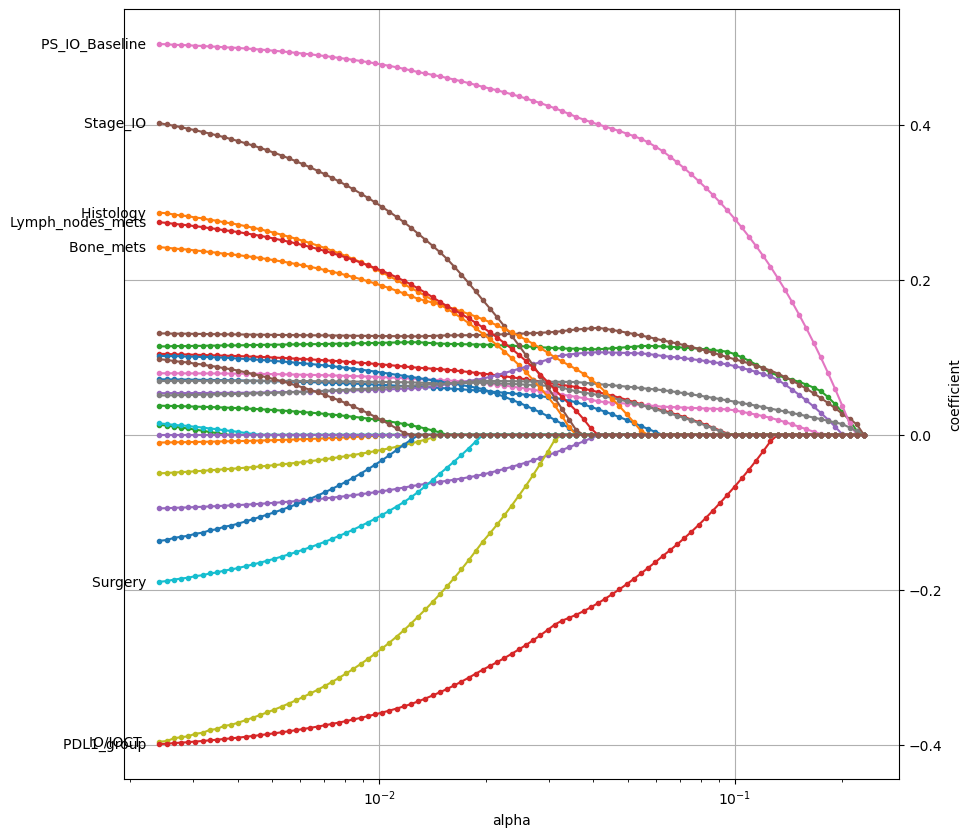

In [36]:
coefficients_elastic_net = pd.DataFrame(
    cox_elastic_net.coef_,
    index=X_train.columns,
    columns=np.round(cox_elastic_net.alphas_, 8)
)

plot_coefficients(coefficients_elastic_net,8)

In [37]:
estimated_alphas=cox_elastic_net.alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=0)

gcv = GridSearchCV(
    CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01),
    param_grid={"alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=1)

gcv=gcv.fit(X_train,y_tr)


cv_results = pd.DataFrame(gcv.cv_results_)

C:\Users\feder\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)


In [38]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alphas,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005582,0.003569,0.004434,0.001335,[0.23017629566755807],{'alphas': [0.23017629566755807]},0.641613,0.635382,0.644857,0.500000,0.619409,0.608252,0.054830,99
1,0.002374,0.000467,0.002786,0.000373,[0.21971442778960557],{'alphas': [0.21971442778960557]},0.642459,0.637043,0.659668,0.633105,0.657194,0.645894,0.010687,98
2,0.002402,0.000787,0.003179,0.000395,[0.209728067952906],{'alphas': [0.209728067952906]},0.643050,0.642691,0.662109,0.645471,0.671080,0.652880,0.011591,97
3,0.001797,0.000392,0.003295,0.000401,[0.20019560358311467],{'alphas': [0.20019560358311467]},0.663341,0.672924,0.664714,0.669703,0.675924,0.669321,0.004769,96
4,0.001995,0.000005,0.003189,0.000394,[0.19109640443074644],{'alphas': [0.19109640443074644]},0.686338,0.688040,0.669434,0.672878,0.682060,0.679750,0.007364,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0.003577,0.001337,0.004589,0.001365,[0.0029044954300674907],{'alphas': [0.0029044954300674907]},0.720494,0.677907,0.690104,0.693683,0.687228,0.693883,0.014297,84
95,0.003702,0.000746,0.004594,0.001231,[0.0027724816301522735],{'alphas': [0.0027724816301522735]},0.720832,0.678073,0.689941,0.693683,0.687389,0.693984,0.014380,82
96,0.004187,0.001163,0.003992,0.000628,[0.0026464680611851385],{'alphas': [0.0026464680611851385]},0.721170,0.677741,0.689779,0.693182,0.686743,0.693723,0.014652,85
97,0.003784,0.000744,0.004096,0.000652,[0.0025261820034091103],{'alphas': [0.0025261820034091103]},0.721846,0.677575,0.689128,0.693015,0.686259,0.693564,0.015026,88


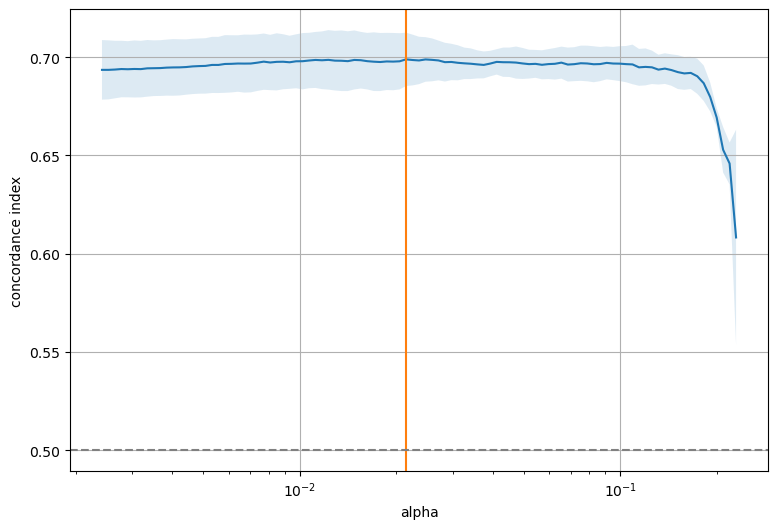

In [39]:
alphas = cv_results.param_alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

In [40]:
gcv.best_params_["alphas"][0]

0.021466318371274686

Number of non-zero coefficients: 17


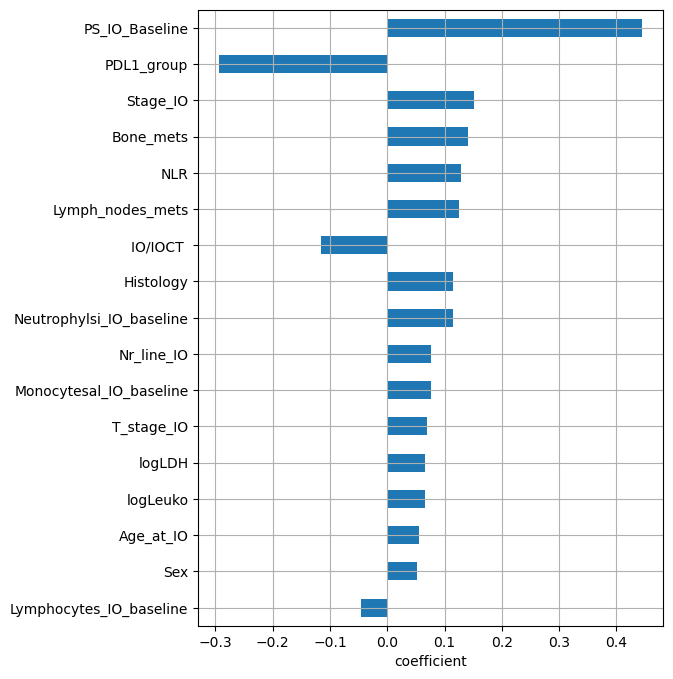

In [41]:
best_model = gcv.best_estimator_
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=X_train.columns,
    columns=["coefficient"]
)

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print("Number of non-zero coefficients: {}".format(non_zero))

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

In [42]:
coefs_best=best_coefs.index[np.where(best_coefs['coefficient']!=0)[0]]
coefs_best


Index(['Age_at_IO', 'Neutrophylsi_IO_baseline', 'Monocytesal_IO_baseline',
       'Lymphocytes_IO_baseline', 'NLR', 'logLeuko', 'logLDH', 'IO/IOCT ',
       'Sex', 'Histology', 'PDL1_group', 'Nr_line_IO', 'Stage_IO',
       'PS_IO_Baseline', 'T_stage_IO', 'Bone_mets', 'Lymph_nodes_mets'],
      dtype='object')

In [43]:
X_tr=X_train.loc[:,coefs_best]
X_t=X_test.loc[:,coefs_best]

In [44]:
X_tr.to_csv("data/survival/OS/X_train_surv.csv")
X_t.to_csv("data/survival/OS/X_test_surv.csv")

y_train.to_csv("data/survival/OS/y_train_surv.csv")
y_test.to_csv("data/survival/OS/y_test_surv.csv")

In [45]:
X_train

,Age_at_IO,BMI_IO_Baseline,Neutrophylsi_IO_baseline,Monocytesal_IO_baseline,Lymphocytes_IO_baseline,NLR,logLeuko,logLDH,IO/IOCT,Surgery,...,PS_IO_Baseline,T_stage_IO,N_stage_IO,Liver_mets,RT_pre_IO,Bone_mets,Pleura_mets,Lymph_nodes_mets,Adrenal_mets,Brain_mets
0,0.203987,-0.374807,-0.483174,-0.201719,0.540926,-0.724860,-0.322171,-0.382325,0,0,...,0,3,2,0,0,0,1,0,1,1
1,0.305040,-1.717817,-0.256717,0.408217,-0.457542,-0.137524,-0.200574,3.675085,0,0,...,1,4,3,1,1,1,0,1,0,1
2,1.012410,-0.387622,-0.707759,0.874638,0.773127,-0.872567,-0.517302,0.040916,1,0,...,1,4,2,0,0,0,0,0,0,0
3,-0.604437,1.716598,0.153152,0.157066,-0.271780,0.057823,0.321461,-0.193898,0,0,...,1,3,3,0,1,0,1,0,0,0
4,-0.200225,-0.098003,-0.352166,-0.201719,-0.387881,-0.279114,-0.394080,-0.703140,0,0,...,1,4,2,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,-0.705490,-0.631107,-1.263609,-0.201719,-0.852284,-1.039034,-0.502898,0.615679,1,0,...,1,1,2,0,0,1,0,0,0,0
587,1.315569,-0.313295,0.003428,0.515852,-0.736184,0.492513,0.082221,0.283123,0,0,...,1,4,2,0,1,0,0,1,0,0
588,0.001881,0.224934,0.789478,1.233424,-0.271780,0.576401,0.942017,-0.622888,0,0,...,0,4,2,0,0,1,0,1,0,0
589,1.719781,0.276194,-0.108865,-0.201719,-0.039579,-0.301695,0.308288,0.171964,0,0,...,1,4,2,0,1,0,0,0,0,0


## ---------------------------------<br><br> SURVIVAL ANALYSIS

### <br><br> CPH model

In [46]:
cox=CoxPHSurvivalAnalysis()
param_grid = {'n_iter': [5,10,15,20,50,100]}
cv = KFold(n_splits=10, random_state=84, shuffle=True)
#cv=StratifiedKFold(10)
gcv = GridSearchCV(cox, param_grid, return_train_score=True, cv=cv)
gcv.fit(X_tr, y_tr)

print("Best score: {f}".format(f=gcv.best_score_))
print("Parameters: {f}".format(f=gcv.best_params_))


# con logaritmo ho migliorato il c-index

C:\Users\feder\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: ConvergenceWarning: Optimization did not converge: Maximum number of iterations has been exceeded.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\feder\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: ConvergenceWarning: Optimization did not converge: Maximum number of iterations has been exceeded.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\feder\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: ConvergenceWarning: Optimization did not converge: Maximum number of iterations has been exceeded.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\feder\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: ConvergenceWarning: Optimization did not converge: Maximum number of iterations has been exceeded.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\feder\anaconda3\lib\site-packages\sklearn\model_selecti

Best score: 0.6995306625387452
Parameters: {'n_iter': 5}


C:\Users\feder\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:910: ConvergenceWarning: Optimization did not converge: Maximum number of iterations has been exceeded.
  self.best_estimator_.fit(X, y, **fit_params)


In [47]:
cox=gcv.best_estimator_
ci_cox_train = concordance_index_censored(y_tr["Status_OS"], y_tr["OS"], cox.predict(X_tr))
ci_cox_test = concordance_index_censored(y_t["Status_OS"], y_t["OS"], cox.predict(X_t))

print("COX PROPORTIONAL HAZARDS\n----------------------")
print("C-index TRAIN: {f}".format(f=ci_cox_train[0]))
print("C-index TEST: {f}".format(f=ci_cox_test[0]))

times_cox = np.linspace(min(y_t['OS']),min(max(cox.event_times_),max(y_t['OS'])-0.001),30)
survs_cox=cox.predict_survival_function(X_t)
preds_cox = np.asarray([[fn(t) for t in times_cox] for fn in survs_cox])

bs_cox=integrated_brier_score(y_tr,y_t,preds_cox,times_cox)
print("Brier Score CPH: ",bs_cox)


COX PROPORTIONAL HAZARDS
----------------------
C-index TRAIN: 0.719437247892959
C-index TEST: 0.775
Brier Score CPH:  0.11380996037132879


### <br><br> Random Survival Forest

In [48]:
rsf = RandomSurvivalForest()
param_grid = {'n_estimators': [200,400],
              'max_depth':[3,5],
              'min_samples_split':[6,8],
              'min_samples_leaf':[7,10]
             }

gcv1 = GridSearchCV(rsf, param_grid, return_train_score=True, cv=cv, verbose=1)
gcv1.fit(X_tr, y_tr)
print("Best score: {f}".format(f=gcv1.best_score_))
print("Parameters: {f}".format(f=gcv1.best_params_))

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Best score: 0.6970898403073018
Parameters: {'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 8, 'n_estimators': 400}


In [49]:
rsf=gcv1.best_estimator_
ci_rsf_train = concordance_index_censored(y_tr["Status_OS"], y_tr["OS"], rsf.predict(X_tr))
# rsf.predict----> calcolo risk score
ci_rsf_test = concordance_index_censored(y_t["Status_OS"], y_t["OS"], rsf.predict(X_t))

print("RANDOM SURVIVAL FOREST\n----------------------")
print("C-index TRAIN: {c}".format(c=ci_rsf_train[0]))
print("C-index TEST: {c}".format(c=ci_rsf_test[0]))


times_rsf = np.linspace(min(y_t['OS']),min(max(rsf.event_times_),max(y_t['OS'])-0.001),30)
survs_rsf=rsf.predict_survival_function(X_t)
preds_rsf = np.asarray([[fn(t) for t in times_rsf] for fn in survs_rsf])

bs_rsf=integrated_brier_score(y_tr,y_t,preds_rsf,times_rsf)
print("Brier Score RSF: ",bs_rsf)

RANDOM SURVIVAL FOREST
----------------------
C-index TRAIN: 0.7711474764700095
C-index TEST: 0.765625
Brier Score RSF:  0.1239360268460142


### <br><br> Gradient Boosting

In [50]:
# criterion='friedman_mse'---> the best criterion (di default)
# loss='coxph' ---> migliore e di default
gb = GradientBoostingSurvivalAnalysis()

param_grid={'n_estimators':[200,400],
           'learning_rate':[0.1,1],
           'min_samples_split':[5,7],
           'min_samples_leaf':[10,15],
           'max_depth':[4,6],
           }


gcv2 = GridSearchCV(gb, param_grid, return_train_score=True, cv=cv, verbose=30, n_jobs=-1)
gcv2.fit(X_tr, y_tr)
print("Best score: {f}".format(f=gcv2.best_score_))
print("Parameters: {f}".format(f=gcv2.best_params_))

Fitting 10 folds for each of 32 candidates, totalling 320 fits
Best score: 0.6837582082079268
Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 200}


In [51]:
gb=gcv2.best_estimator_
ci_gb_train = concordance_index_censored(y_tr["Status_OS"], y_tr["OS"], gb.predict(X_tr))
ci_gb_test = concordance_index_censored(y_t["Status_OS"], y_t["OS"], gb.predict(X_t))

print("GRADIENT BOOSTING\n----------------------")
print("C-index TRAIN: {f}".format(f=ci_gb_train[0]))
print("C-index TEST: {f}".format(f=ci_gb_test[0]))

times_gb = np.linspace(min(y_t['OS']),min(max(gb.event_times_),max(y_t['OS'])-0.001),30)
survs_gb=gb.predict_survival_function(X_t)
preds_gb = np.asarray([[fn(t) for t in times_gb] for fn in survs_gb])

bs_gb=integrated_brier_score(y_tr,y_t,preds_gb,times_gb)
print("Brier Score GB: ",bs_gb)


GRADIENT BOOSTING
----------------------
C-index TRAIN: 0.9001541337356115
C-index TEST: 0.759375
Brier Score GB:  0.11479602461447441


### <br><br> FastKernelSurvival SVM

In [52]:
fks=FastKernelSurvivalSVM()
param_grid={"kernel":['linear','rbf','polinomial'], "alpha":[0.1,1,10],"gamma":[1,2], "degree":[2,3,4]}

gcv3 = GridSearchCV(fks, param_grid, return_train_score=True, cv=cv, verbose=1, n_jobs=-1)
gcv3.fit(X_tr, y_tr)
print("Best score: {f}".format(f=gcv3.best_score_))
print("Parameters: {f}".format(f=gcv3.best_params_))

Fitting 10 folds for each of 54 candidates, totalling 540 fits


C:\Users\feder\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
180 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\feder\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\feder\AppData\Roaming\Python\Python310\site-packages\sksurv\svm\survival_svm.py", line 713, in fit
    opt_result = self._fit(X, time, event, samples_order)
  File "C:\Users\feder\AppData\Roaming\Python\Python310\site-packages\sksurv\svm\survival_svm.py", line 1051, in _fit
    kernel_mat 

Best score: 0.7076482845136636
Parameters: {'alpha': 0.1, 'degree': 2, 'gamma': 1, 'kernel': 'linear'}


In [53]:
fks=gcv3.best_estimator_
ci_fks_train = concordance_index_censored(y_tr["Status_OS"], y_tr["OS"], fks.predict(X_tr))
ci_fks_test = concordance_index_censored(y_t["Status_OS"], y_t["OS"], fks.predict(X_t))

print("FAST KERNEL SSVM\n----------------------")
print("C-index TRAIN: {f}".format(f=ci_fks_train[0]))
print("C-index TEST: {f}".format(f=ci_fks_test[0]))

# SSVM non ha predict survival function (GB, CPH e RSF invece sì)

FAST KERNEL SSVM
----------------------
C-index TRAIN: 0.7247040304332142
C-index TEST: 0.7869791666666667


### <br><br> ExtraTree

In [54]:
et = ExtraSurvivalTrees()
param_grid = {'n_estimators': [200,400],
              'max_depth':[3,5],
              'min_samples_split':[6,8],
              'min_samples_leaf':[7,10]
             }

gcv4 = GridSearchCV(et, param_grid, return_train_score=True, cv=cv)
gcv4.fit(X_tr, y_tr)
print("Best score: {f}".format(f=gcv4.best_score_))
print("Parameters: {f}".format(f=gcv4.best_params_))

Best score: 0.6983405147566004
Parameters: {'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 8, 'n_estimators': 400}


In [55]:
et=gcv4.best_estimator_
ci_et_train = concordance_index_censored(y_tr["Status_OS"], y_tr["OS"], et.predict(X_tr))
ci_et_test = concordance_index_censored(y_t["Status_OS"], y_t["OS"], et.predict(X_t))

print("EXTRA TREES\n----------------------")
print("C-index TRAIN: {f}".format(f=ci_et_train[0]))
print("C-index TEST: {f}".format(f=ci_et_test[0]))

times_et = np.linspace(min(y_t['OS']),min(max(et.event_times_),max(y_t['OS'])-0.001),30)
survs_et=et.predict_survival_function(X_t)
preds_et = np.asarray([[fn(t) for t in times_et] for fn in survs_et])

bs_et=integrated_brier_score(y_tr,y_t,preds_et,times_et)
print("Brier Score ET: ",bs_et)

EXTRA TREES
----------------------
C-index TRAIN: 0.7296297510904142
C-index TEST: 0.7609375
Brier Score ET:  0.13198041165990423


## <br><br> XGBoost

In [251]:
from xgbse.metrics import concordance_index, approx_brier_score
from xgbse.non_parametric import get_time_bins
from xgbse import (
    XGBSEKaplanNeighbors,
    XGBSEKaplanTree,
    XGBSEDebiasedBCE,
    XGBSEBootstrapEstimator
)
from xgbse.converters import (
    convert_data_to_xgb_format,
    convert_to_structured
)

In [250]:
def plot_ci(mean, upper_ci, lower_ci, i=42, title='Probability of survival $P(T \geq t)$'):
    
    # plotting mean and confidence intervals
    plt.figure(figsize=(12, 4), dpi=120)
    plt.plot(mean.columns,mean.iloc[i])
    plt.fill_between(mean.columns, lower_ci.iloc[i], upper_ci.iloc[i], alpha=0.2)

    plt.title(title)
    plt.xlabel('Time [days]')
    plt.ylabel('Probability')
    plt.tight_layout()

In [322]:
times_xgb=np.linspace(min(y_t['OS'])+0.001,max(y_t['OS']-0.001),100)

C-index train: 0.7329349545018536
C-index CV: 0.6973542242993213
C-index test: 0.7474907554146857
---------------------------------------
Brier Score train: 0.12727162379774365
Brier Score CV: 0.15119262228971073
Brier Score test: 0.1334725610469247


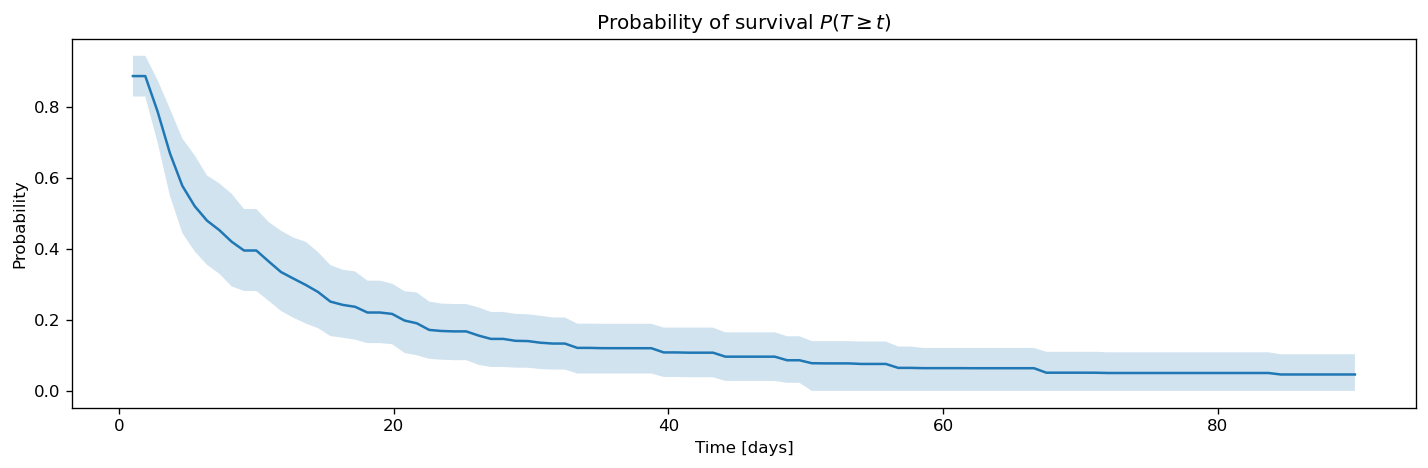

In [280]:
PARAMS_TREE = {
    'objective': 'survival:aft',
    'eval_metric': 'cox-nloglik',
    'tree_method': 'hist', 
    'max_depth': 12, 
    'booster':'dart', 
    'subsample': 1,
    'min_child_weight': 50, 
    'colsample_bynode': 1,
    'learning_rate': 1e-4
}

# base model as XGBSEKaplanTree
base_model = XGBSEKaplanTree(PARAMS_TREE)

# bootstrap meta estimator
bootstrap_estimator = XGBSEBootstrapEstimator(base_model, n_estimators=600)



# fitting the meta estimator
bootstrap_estimator.fit(X_tr, y_tr, time_bins=times_xgb)

# predicting
mean_tr, upper_ci_tr, lower_ci_tr = bootstrap_estimator.predict(X_tr, return_ci=True)
mean_t, upper_ci_t, lower_ci_t = bootstrap_estimator.predict(X_t, return_ci=True)

# print metrics
print(f"C-index train: {concordance_index(y_tr, mean_tr)}")
cind_cv = cross_val_score(bootstrap_estimator, X_tr, y_tr, scoring=make_scorer(concordance_index), cv=10)
print("C-index CV: {f}".format(f=st.mean(cind_cv)))
print(f"C-index test: {concordance_index(y_t, mean_t)}")
print("---------------------------------------")
print(f"Brier Score train: {approx_brier_score(y_tr, mean_tr)}")
brier_cv = cross_val_score(bootstrap_estimator, X_tr, y_tr, scoring=make_scorer(approx_brier_score), cv=10)
print("Brier Score CV: {f}".format(f=st.mean(brier_cv)))
print(f"Brier Score test: {approx_brier_score(y_t, mean_t)}")

# plotting CIs
plot_ci(mean_t, upper_ci_t, lower_ci_t)

In [290]:
xgb_risk_scores = 1 - mean_t.mean(axis=1)

Average XGB:  0.8328507684011177


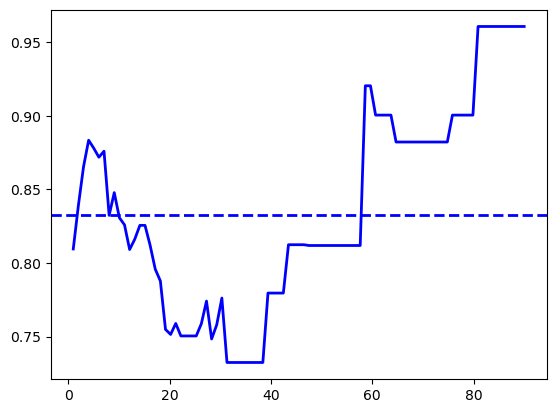

## DeepSurv



In [ ]:
import pycox
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt


In [125]:
np.random.seed(123)
_ = torch.manual_seed(123)

In [126]:
X_train_DS, X_val, y_train_DS, y_val = train_test_split(X_train, y_train, random_state=84, test_size = 0.1)

In [127]:
x_tr=np.array(X_train_DS).astype('float32')
x_t=np.array(X_test).astype('float32')
#x_tr=np.array(X_train).astype('float32')
x_val=np.array(X_val).astype('float32')
#x_val

In [128]:
get_target = lambda df: (df['OS'].values, df['Status_OS'].values)
Y_tr=get_target(y_train_DS)
#Y_tr=get_target(y_train)
Y_val=get_target(y_val)
Y_t=get_target(y_test)
#Y_tr

In [129]:
in_features = x_tr.shape[1]
num_nodes = [32,32]
out_features = 1
batch_norm = True
dropout = 0.2
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

Best learning rate:  0.002595024211399749


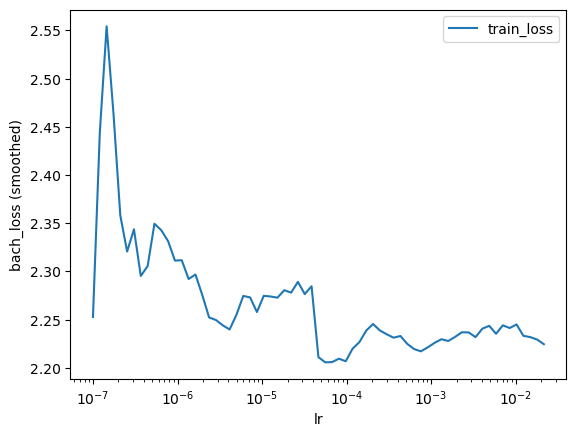

In [130]:
# INPUT DEVONO ESSERE DEGLI ARRAY
batch_size = 16#X_tr.shape[0]

model = CoxPH(net, tt.optim.Adam)
lrfinder = model.lr_finder(x_tr, Y_tr, batch_size, tolerance=10)
_ = lrfinder.plot()  #---> PLOTTA ANDAMENTO
print("Best learning rate: ",lrfinder.get_best_lr())
model.optimizer.set_lr(1e-4)

In [138]:
epochs = 512
#callbacks = [tt.callbacks.EarlyStopping()]
#verbose = True

In [139]:
'''def flatten(l):
    return [item for sublist in l for item in sublist]

#  ---------------------- CROSS-VALIDATION --------------------------
def cross_validation_deepsurv(X, y, n_folds, mod):
    X_train_cv=[]
    y_train_cv=[]
    step=round(X.shape[0]/n_folds)
    scores=[]
    for i in range(n_folds):
        if(step*(i+1)>X.shape[0]):
            X_cv=X[step*i:X.shape[0]+1,:]
            y_cv=y[step*i:X.shape[0]+1]
        else:
            X_cv=X[step*i:step*(i+1),:]
            y_cv=y[step*i:step*(i+1)]
        X_train_cv.append(X_cv)
        y_train_cv.append(y_cv)

    for i in range(n_folds):
        X_cv_tr=X_train_cv.copy()
        X_cv_t=X_cv_tr[n_folds-1-i]
        X_cv_tr.pop(n_folds-1-i)

        y_cv_tr=y_train_cv.copy()
        y_cv_t=y_cv_tr[n_folds-1-i]
        y_cv_tr.pop(n_folds-1-i)

        y_CV_tr=get_target(pd.concat([t for t in y_cv_tr],axis=0))
        X_CV_tr=np.array(flatten(X_cv_tr))
        mod.fit(X_CV_tr, y_CV_tr, batch_size, epochs,  verbose=False)
        _ = mod.compute_baseline_hazards()
        surv_train = mod.predict_surv_df(X_cv_t)

        durations, events = get_target(y_cv_t)
        time_grid = np.linspace(durations.min(), durations.max(), 100)

        ev = EvalSurv(surv_train, durations, events, censor_surv='km')
        cind=ev.concordance_td()
        scores.append(cind)
        print("{j} fits completed".format(j=i+1))
        
    
    return scores

        '''


'def flatten(l):\n    return [item for sublist in l for item in sublist]\n\n#  ---------------------- CROSS-VALIDATION --------------------------\ndef cross_validation_deepsurv(X, y, n_folds, mod):\n    X_train_cv=[]\n    y_train_cv=[]\n    step=round(X.shape[0]/n_folds)\n    scores=[]\n    for i in range(n_folds):\n        if(step*(i+1)>X.shape[0]):\n            X_cv=X[step*i:X.shape[0]+1,:]\n            y_cv=y[step*i:X.shape[0]+1]\n        else:\n            X_cv=X[step*i:step*(i+1),:]\n            y_cv=y[step*i:step*(i+1)]\n        X_train_cv.append(X_cv)\n        y_train_cv.append(y_cv)\n\n    for i in range(n_folds):\n        X_cv_tr=X_train_cv.copy()\n        X_cv_t=X_cv_tr[n_folds-1-i]\n        X_cv_tr.pop(n_folds-1-i)\n\n        y_cv_tr=y_train_cv.copy()\n        y_cv_t=y_cv_tr[n_folds-1-i]\n        y_cv_tr.pop(n_folds-1-i)\n\n        y_CV_tr=get_target(pd.concat([t for t in y_cv_tr],axis=0))\n        X_CV_tr=np.array(flatten(X_cv_tr))\n        mod.fit(X_CV_tr, y_CV_tr, batch_s

In [140]:
#scores=cross_validation_deepsurv(x_tr,y_train,10,model)
val = x_val, Y_val

In [141]:
log = model.fit(x_tr, Y_tr, batch_size, epochs,  verbose=False,
                val_data=val, val_batch_size=batch_size)

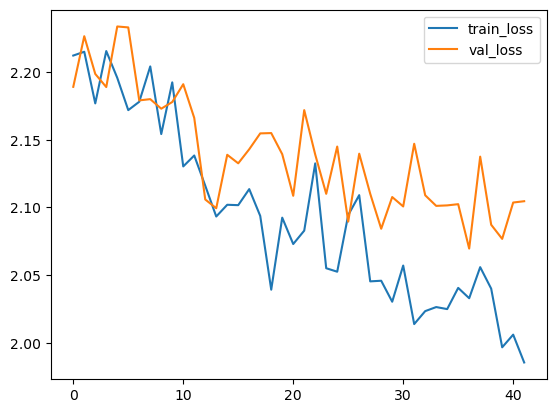

In [142]:
_ = log.plot()

In [143]:
_ = model.compute_baseline_hazards()
surv_df_test = model.predict_surv_df(x_t)
surv_df_train = model.predict_surv_df(x_tr)
surv_df_val = model.predict_surv_df(x_val)

In [144]:
surv_df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
duration,,,,,,,,,,,,,,,,,,,,,
0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


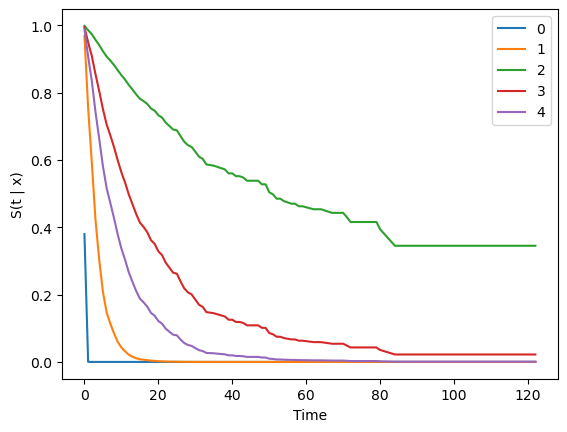

In [118]:
surv_df_test.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [120]:
durations_test, events_test = get_target(y_test)
durations_train, events_train = get_target(y_train_DS)
#durations_train, events_train = get_target(y_train)
durations_val, events_val = get_target(y_val)
time_grid_test = np.linspace(durations_test.min(), durations_test.max(), 100)
time_grid_tr = np.linspace(durations_train.min(), durations_train.max(), 100)
time_grid_val = np.linspace(durations_val.min(), durations_val.max(), 100)

In [121]:
ev_test = EvalSurv(surv_df_test, durations_test, events_test, censor_surv='km')
ev_train = EvalSurv(surv_df_train, durations_train, events_train, censor_surv='km')
ev_val = EvalSurv(surv_df_val, durations_val, events_val, censor_surv='km')

C:\Users\feder\anaconda3\lib\site-packages\pycox\evaluation\eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
C:\Users\feder\anaconda3\lib\site-packages\pycox\evaluation\eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


In [122]:
print("C-index train: ",ev_train.concordance_td())
print("C-index validation: ",ev_val.concordance_td())
print("C-index test:", ev_test.concordance_td())

C-index train:  0.771523464458247
C-index test: 0.7634302612124199


In [123]:
print("Brier Score train: ", ev_train.integrated_brier_score(time_grid_tr))
print("Brier Score validation : ", ev_test.integrated_brier_score(time_grid_val))
print("Brier Score test : ", ev_test.integrated_brier_score(time_grid_test))

Brier Score train:  0.09604876362861428
Brier Score test :  0.13811130185038087


In [74]:
mlp_risk_scores = 1 - surv_df_test.mean(axis=0)

In [75]:
times = time_grid_test[1:-1]

In [76]:
mlp_auc, mlp_mean_auc = cumulative_dynamic_auc(
    y_tr, y_t, mlp_risk_scores, times
)

print("Average MLP: ", mlp_mean_auc)
times = np.linspace(times.min(),times.max(),mlp_auc.size)
plt.plot(times, mlp_auc, "b-",label="DeepSurv", linewidth=2)
plt.axhline(mlp_mean_auc, linestyle="--", color="b",linewidth=2)
plt.grid(True)

ValueError: Input estimate contains NaN.

## <br><br> Evaluating Survival Models

### Time dependent AUC

In [325]:
times_fks = np.linspace(min(y_t['OS']),max(y_t['OS'])-0.001,30)

Average SSVM:  0.7884158265049018
Average CPH:  0.77746437848877
Average RSF:  0.8227017590761144
Average ETS:  0.745828306270706
Average GB:  0.785166200041176


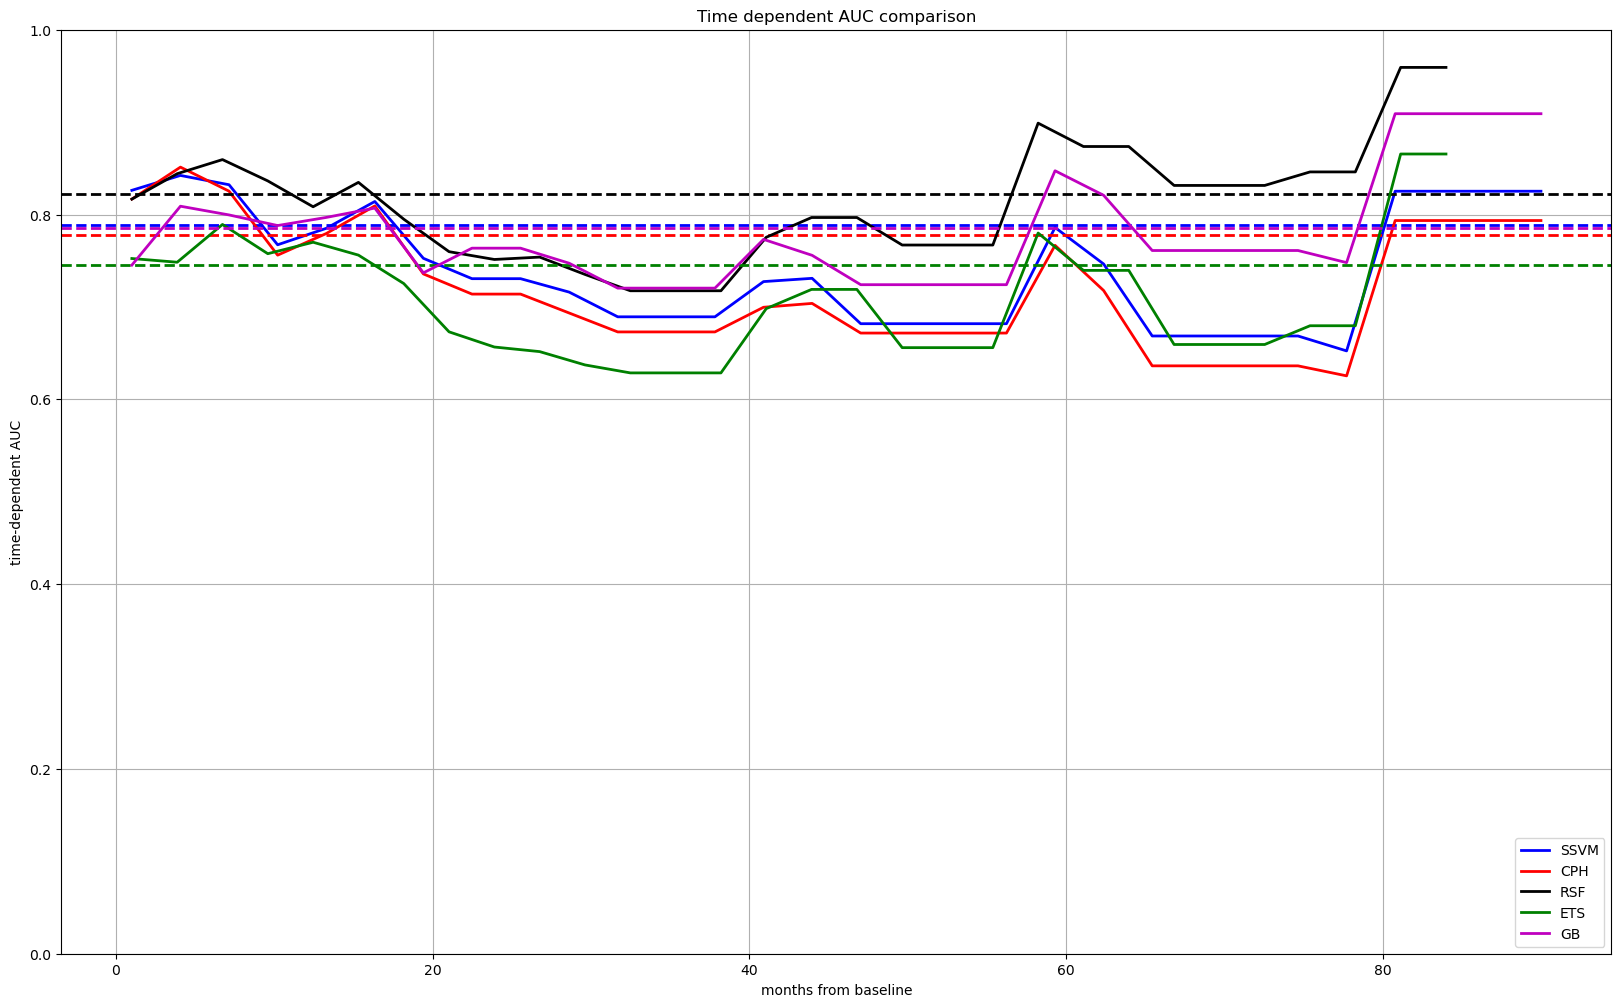

In [349]:
fks_risk_scores=fks.predict(X_t)
fks_auc, fks_mean_auc = cumulative_dynamic_auc(
    y_tr, y_t, fks_risk_scores, times_cox
)

cox_risk_scores=cox.predict(X_t)
cox_auc, cox_mean_auc = cumulative_dynamic_auc(
    y_tr, y_t, cox_risk_scores, times_cox
)

et_risk_scores=et.predict(X_t)
et_auc, et_mean_auc = cumulative_dynamic_auc(
    y_tr, y_t, et_risk_scores, times_et
)

rsf_risk_scores=rsf.predict(X_t)
rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(
    y_tr, y_t, rsf_risk_scores, times_rsf
)





# mlp_auc, mlp_mean_auc = cumulative_dynamic_auc(
#    y_tr, y_t, mlp_risk_scores, times
#  )

gb_risk_scores=gb.predict(X_t)
gb_auc, gb_mean_auc = cumulative_dynamic_auc(
    y_tr, y_t, gb_risk_scores, times_gb
)


times_plotXGB=np.linspace(min(y_t['OS'])+0.001,max(y_t['OS']-0.001),xgb_auc.shape[0])


plt.figure(figsize=(20,12))
plt.plot(times_fks, fks_auc, "b-",label="SSVM", linewidth=2)
plt.axhline(fks_mean_auc, linestyle="--", color="b",linewidth=2)
plt.plot(times_cox, cox_auc, "r-",label="CPH", linewidth=2)
plt.axhline(cox_mean_auc, linestyle="--", color="r",linewidth=2)
plt.plot(times_rsf, rsf_auc, "k-",label="RSF", linewidth=2)
plt.axhline(rsf_mean_auc, linestyle="--", color="k",linewidth=2)
plt.plot(times_et, et_auc, "g-",label="ETS", linewidth=2)
plt.axhline(et_mean_auc, linestyle="--", color="g",linewidth=2)
plt.plot(times_gb,gb_auc, "m-",label="GB", linewidth=2)
plt.axhline(gb_mean_auc, linestyle="--", color="m",linewidth=2)

#plt.plot(times, mlp_auc, "y-",label="DS", linewidth=2)
#plt.axhline(mlp_mean_auc, linestyle="--", color="y",linewidth=2)

plt.xlabel("months from baseline")
plt.ylabel("time-dependent AUC")
plt.ylim(0,1)
plt.title("Time dependent AUC comparison")
plt.legend(loc="lower right")
plt.grid(True)

print("Average SSVM: ",fks_mean_auc)
print("Average CPH: ",cox_mean_auc)
print("Average RSF: ",rsf_mean_auc)
print("Average ETS: ",et_mean_auc)

#print("Average DS: ",mlp_mean_auc)
print("Average GB: ",gb_mean_auc)

plt.savefig("results/survival/OS/DynamicAUC.png", format='png')

### <br><br>  Estimation of Survival Functions

In [330]:
# KAPLAN MEIER ESTIMATION FOR SURVIVAL CURVE 
t_km, surv_km = kaplan_meier_estimator(y_tr['Status_OS'],y_tr['OS'])

In [331]:
preds_rsf_func = [[fn(t) for t in rsf.event_times_] for fn in survs_rsf]
t=rsf.event_times_

In [332]:
surv=pd.DataFrame(preds_rsf_func)
mean_surv=surv.mean()

# PAZIENTI SCELTI DEVE ESSERE MORTI!!

surv['OS']=y_t['OS']
surv['Event']=y_t['Status_OS']
surv

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,OS,Event
0,0.969058,0.871899,0.759194,0.649397,0.559665,0.516321,0.496258,0.469754,0.435279,0.395294,...,0.106519,0.105747,0.105546,0.105546,0.102811,0.102567,0.102038,0.099839,10,True
1,0.996371,0.953213,0.920363,0.882687,0.854002,0.809253,0.780085,0.738733,0.709564,0.677556,...,0.239856,0.236420,0.235822,0.233561,0.232582,0.223557,0.211502,0.199286,75,False
2,0.971912,0.878022,0.777619,0.670426,0.541317,0.488967,0.455549,0.412908,0.383850,0.363352,...,0.084596,0.083413,0.083413,0.083282,0.074598,0.074598,0.073718,0.070241,9,True
3,0.987277,0.933992,0.883783,0.815879,0.770772,0.722448,0.684760,0.660425,0.626077,0.585004,...,0.136426,0.127446,0.122908,0.121562,0.113091,0.112093,0.106476,0.100171,14,False
4,0.998621,0.974257,0.922029,0.897371,0.860041,0.805263,0.770673,0.736880,0.686278,0.653875,...,0.155768,0.154286,0.152570,0.137052,0.130843,0.122452,0.103199,0.090807,80,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,0.995835,0.955112,0.907177,0.861834,0.814382,0.756264,0.703987,0.672456,0.640148,0.602346,...,0.122168,0.120493,0.118826,0.109789,0.107672,0.101656,0.092690,0.062747,16,True
63,0.987370,0.930214,0.878485,0.801591,0.749607,0.709748,0.680739,0.654183,0.627627,0.584725,...,0.163300,0.157839,0.155422,0.154491,0.146218,0.141288,0.138438,0.129817,21,False
64,0.980483,0.942884,0.900341,0.842651,0.783723,0.745745,0.710896,0.689808,0.667978,0.634839,...,0.200690,0.196901,0.189858,0.185966,0.174738,0.171791,0.171488,0.155363,17,True
65,0.987934,0.919498,0.865780,0.814870,0.777365,0.723937,0.671678,0.641132,0.608347,0.578055,...,0.126920,0.123305,0.119383,0.117323,0.112140,0.110016,0.106818,0.093840,17,True


In [333]:
surv_low=surv['OS']<=5
surv_low=surv[surv_low]
surv_low
# I choose patient 5 (OS=2)

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,OS,Event
5,0.869586,0.625913,0.489942,0.372173,0.298823,0.268597,0.241707,0.227127,0.203258,0.186879,...,0.063889,0.063578,0.063244,0.063244,0.062462,0.062217,0.062217,0.060656,2,True
9,0.982626,0.938162,0.868872,0.800424,0.715695,0.655684,0.606222,0.579656,0.547332,0.501249,...,0.085634,0.080630,0.075295,0.072335,0.057844,0.055167,0.053115,0.041798,1,True
13,0.990481,0.953714,0.911030,0.850321,0.791757,0.747796,0.697457,0.660666,0.631858,0.592146,...,0.113655,0.110951,0.105503,0.101972,0.093778,0.091107,0.088936,0.077681,4,True
15,0.947640,0.809354,0.687128,0.530984,0.427107,0.383401,0.347514,0.325747,0.296708,0.276061,...,0.059659,0.058264,0.054653,0.054341,0.050114,0.050114,0.049048,0.045593,1,True
19,0.993019,0.930662,0.871615,0.817227,0.762160,0.698140,0.634021,0.605493,0.570574,0.542828,...,0.100371,0.091850,0.084185,0.081788,0.075989,0.074793,0.068946,0.065076,2,True
20,0.969213,0.850723,0.714834,0.594833,0.482817,0.423372,0.394858,0.376400,0.339413,0.313060,...,0.053492,0.047441,0.047123,0.047123,0.042604,0.042604,0.041418,0.041418,5,True
21,0.977512,0.874264,0.791171,0.699030,0.637597,0.581742,0.507705,0.490769,0.448922,0.412008,...,0.083076,0.078608,0.072202,0.070333,0.059079,0.057357,0.052991,0.044154,4,True
25,0.995720,0.938061,0.866149,0.809820,0.736863,0.657572,0.615360,0.587132,0.545653,0.505635,...,0.087841,0.078691,0.074479,0.072946,0.060776,0.058727,0.047471,0.044409,4,True
26,0.986519,0.912841,0.861399,0.784381,0.741073,0.688382,0.632090,0.606797,0.578994,0.532890,...,0.152641,0.150957,0.142154,0.139055,0.135596,0.133368,0.131604,0.108752,5,True
34,0.990454,0.819343,0.729096,0.609332,0.528811,0.458862,0.404985,0.378268,0.341727,0.310599,...,0.041006,0.038136,0.035710,0.035140,0.031164,0.030763,0.025780,0.023473,1,True


In [335]:
# SURVIVAL CURVE FOR PATIENT WITH HIGH OS
surv_high=surv['OS']>=30
surv_high=surv[surv_high]
surv_high
# I choose patient 6 (OS=47)

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,OS,Event
1,0.996371,0.953213,0.920363,0.882687,0.854002,0.809253,0.780085,0.738733,0.709564,0.677556,...,0.239856,0.236420,0.235822,0.233561,0.232582,0.223557,0.211502,0.199286,75,False
4,0.998621,0.974257,0.922029,0.897371,0.860041,0.805263,0.770673,0.736880,0.686278,0.653875,...,0.155768,0.154286,0.152570,0.137052,0.130843,0.122452,0.103199,0.090807,80,True
6,0.996829,0.967293,0.933682,0.899879,0.871365,0.837550,0.805985,0.784988,0.759835,0.731284,...,0.192641,0.188622,0.182065,0.179350,0.174030,0.172102,0.169991,0.157313,47,True
11,0.994716,0.975056,0.956413,0.931472,0.896685,0.856791,0.819782,0.798403,0.771668,0.748903,...,0.282846,0.281646,0.279615,0.269445,0.266118,0.256737,0.252106,0.209811,31,True
14,0.998013,0.983441,0.967034,0.940240,0.922012,0.892076,0.860144,0.834973,0.819453,0.793446,...,0.378562,0.377283,0.376108,0.369232,0.368337,0.357213,0.353915,0.322167,64,False
22,0.992987,0.959529,0.921049,0.866643,0.810420,0.759071,0.706504,0.685118,0.654527,0.613304,...,0.127030,0.122284,0.110572,0.106399,0.097608,0.092986,0.083120,0.073228,43,True
43,0.976444,0.886780,0.791765,0.711928,0.640671,0.591390,0.555775,0.522197,0.488250,0.459686,...,0.108326,0.106360,0.105422,0.104512,0.100427,0.100266,0.099111,0.094490,30,False
47,0.984006,0.885444,0.817714,0.727729,0.656132,0.590887,0.563354,0.531011,0.494166,0.465445,...,0.114676,0.099008,0.096988,0.096372,0.093189,0.093065,0.089396,0.083737,39,True
48,0.995589,0.963387,0.919874,0.877891,0.848643,0.792633,0.757547,0.731104,0.704515,0.665558,...,0.166746,0.163174,0.156162,0.149986,0.145835,0.138016,0.136937,0.104453,30,True
51,0.997394,0.984706,0.964859,0.935026,0.907988,0.875310,0.834622,0.811359,0.786621,0.745891,...,0.238179,0.237756,0.228478,0.211866,0.207693,0.191269,0.180813,0.144400,90,False


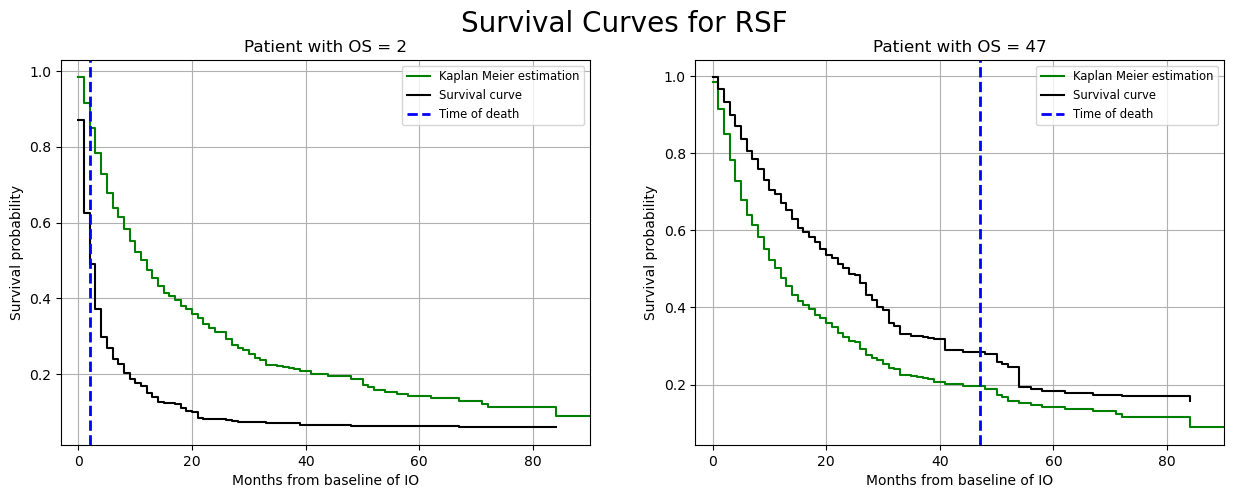

In [348]:
#for pred in preds_cox_func:
#    plt.step(t, pred, where="post", color="k")

plt.figure(figsize=(15,5))


plt.subplot(1,2,1)
plt.step(t_km, surv_km, where="post", color="g", label="Kaplan Meier estimation")
plt.step(t, surv.iloc[5,:-2], where="post", color="k", label="Survival curve")
plt.axvline(surv.loc[5,'OS'], linestyle="--", color="b",linewidth=2, label="Time of death")
plt.legend(loc="best", fontsize='small')
plt.title("Patient with OS = {os}".format(os=surv.loc[5,'OS']))
plt.xlabel("Months from baseline of IO")
plt.ylabel("Survival probability")
plt.xlim(left=-3,right=max(y_t['OS']))
plt.grid(True)

plt.subplot(1,2,2)
plt.step(t_km, surv_km, where="post", color="g", label="Kaplan Meier estimation")
plt.step(t, surv.iloc[6,:-2], where="post", color="k", label="Survival curve")
plt.axvline(surv.loc[6,'OS'], linestyle="--", color="b",linewidth=2, label="Time of death")
plt.legend(loc="best", fontsize='small')
plt.title("Patient with OS = {os}".format(os=surv.loc[6,'OS']))
plt.xlabel("Months from baseline of IO")
plt.ylabel("Survival probability")
plt.xlim(left=-3,right=max(y_t['OS']))
plt.grid(True)

plt.suptitle("Survival Curves for RSF",fontsize=20)

plt.savefig("results/survival/OS/Survival curves.png", format='png')
plt.show()


In [276]:
cph_results=pd.DataFrame(gcv.cv_results_)
#cph_results=cph_results.loc[:,['params','mean_test_score','std_test_score']]
cph_results
                        

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.065191,0.006299,0.001564,0.004692,5,{'n_iter': 5},0.733333,0.755784,0.741886,0.755008,...,0.766894,0.770772,0.766556,0.767023,0.767488,0.773618,0.763271,0.76531,0.768069,0.002880
1,0.089758,0.010101,0.000667,0.001340,10,{'n_iter': 10},0.733333,0.755784,0.741886,0.755008,...,0.766894,0.770720,0.766487,0.767023,0.767506,0.773618,0.763289,0.76531,0.768059,0.002875
2,0.089028,0.015560,0.003130,0.006259,15,{'n_iter': 15},0.733333,0.755784,0.741886,0.755008,...,0.766894,0.770720,0.766487,0.767023,0.767506,0.773618,0.763289,0.76531,0.768059,0.002875
3,0.085925,0.010476,0.003125,0.006249,20,{'n_iter': 20},0.733333,0.755784,0.741886,0.755008,...,0.766894,0.770720,0.766487,0.767023,0.767506,0.773618,0.763289,0.76531,0.768059,0.002875
4,0.084384,0.012491,0.003116,0.006232,50,{'n_iter': 50},0.733333,0.755784,0.741886,0.755008,...,0.766894,0.770720,0.766487,0.767023,0.767506,0.773618,0.763289,0.76531,0.768059,0.002875
5,0.082804,0.009998,0.001557,0.004672,100,{'n_iter': 100},0.733333,0.755784,0.741886,0.755008,...,0.766894,0.770720,0.766487,0.767023,0.767506,0.773618,0.763289,0.76531,0.768059,0.002875
